# Summer Coding League 💻
## Week 3 - Data Science
### *Predicting subscribtions*

------------------------------------

<img src='https://www.forbes.com/advisor/wp-content/uploads/2019/08/gettyimages-1050881944-612x612-e1565718161876.jpg'>

## 📌BACKGROUND
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

## 📌TASK
Create a predictive algorithm (Machine Learning, NOT ANN) to predict if a client will subscribe to a term deposit (variable y)

## 📌DATASETS
*Input variables: bank client data:*

* 1 - age (numeric)
* 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
* 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* 4 - education (categorical: "unknown","secondary","primary","tertiary")
* 5 - default: has credit in default? (binary: "yes","no")
* 6 - balance: average yearly balance, in euros (numeric)
* 7 - housing: has housing loan? (binary: "yes","no")
* 8 - loan: has personal loan? (binary: "yes","no") related with the last contact of the current campaign:
* 9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
* 10 - day: last contact day of the month (numeric)
* 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* 12 - duration: last contact duration, in seconds (numeric) other attributes:
* 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* 15 - previous: number of contacts performed before this campaign and for this client (numeric)
* 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
Output variable (desired target):
* 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

## 📌Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


## 📌Importing Data

In [2]:
df = pd.read_csv('train.csv')
X_test = pd.read_csv('x_test.csv')

In [3]:
# Showing the first rows of our Dataset
display(df.head(3))
display(df.info())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31430 entries, 0 to 31429
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31430 non-null  int64 
 1   job        31430 non-null  object
 2   marital    31430 non-null  object
 3   education  31430 non-null  object
 4   default    31430 non-null  object
 5   balance    31430 non-null  int64 
 6   housing    31430 non-null  object
 7   loan       31430 non-null  object
 8   contact    31430 non-null  object
 9   day        31430 non-null  int64 
 10  month      31430 non-null  object
 11  duration   31430 non-null  int64 
 12  campaign   31430 non-null  int64 
 13  pdays      31430 non-null  int64 
 14  previous   31430 non-null  int64 
 15  poutcome   31430 non-null  object
 16  y          31430 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.1+ MB


None

In [4]:
# An statistical approach of our numerical features
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,31430.0,41.114445,9.589084,19.0,33.0,40.0,49.0,94.0
balance,31430.0,1290.419408,2962.444111,-8019.0,46.0,396.0,1325.0,98417.0
day,31430.0,16.667992,8.540192,1.0,9.0,18.0,23.0,31.0
duration,31430.0,251.730640,261.707203,0.0,98.0,170.0,305.0,4918.0
campaign,31430.0,3.070029,3.518305,1.0,1.0,2.0,3.0,63.0
pdays,31430.0,10.354693,46.910901,-1.0,-1.0,-1.0,-1.0,294.0
previous,31430.0,0.202227,1.940676,0.0,0.0,0.0,0.0,275.0


As we could see, we don't have null values in our data (so we don't have to deal with filling methodologies) and the data types seem to be correct

In [5]:
df['pdays'].value_counts()

-1      29449
 182       41
 189       39
 183       38
 2         35
        ...  
 146        1
 86         1
 277        1
 21         1
 24         1
Name: pdays, Length: 222, dtype: int64

💡 Looking into 'pDays' values, we notice that the value -1 represents absence of a previous call. Due we have the same information in the feature "previous", I decided to change the -1 value directly to 0, to avoid possible false signals to our algorithm

In [6]:
df['pdays'] =  df['pdays'].apply(lambda x: x if x!=-1 else 0)

In [7]:
df['pdays'].value_counts()

0      29449
182       41
189       39
183       38
2         35
       ...  
282        1
29         1
27         1
219        1
146        1
Name: pdays, Length: 222, dtype: int64

## 📌A brief approach to our data

### 💡*Chasing Outliers*

#### A) Balance

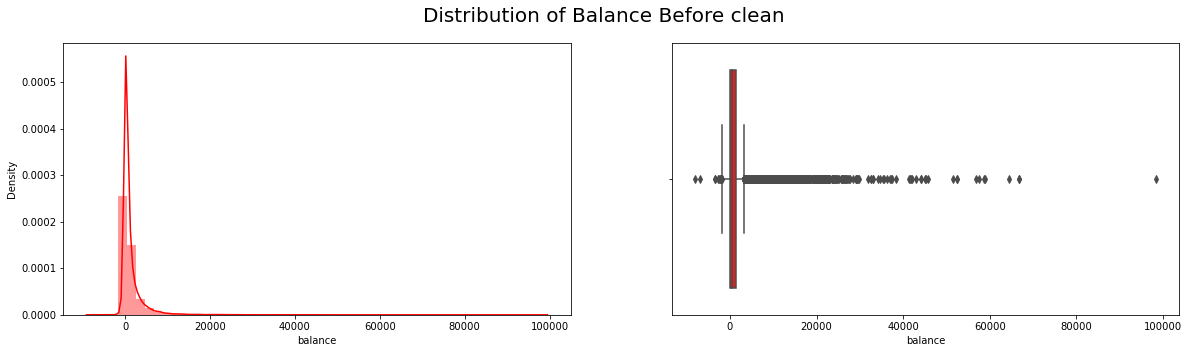

In [8]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20,5))
plt.suptitle('Distribution of Balance Before clean', size=20)
plt.subplot(1,2,1)
sns.distplot(df['balance'],color='r')
plt.subplot(1,2,2)
sns.boxplot(df['balance'],color='r')
plt.show()

In [9]:
percentile25 = df['balance'].quantile(0.25)
percentile75 = df['balance'].quantile(0.75)
iqr = percentile75 - percentile25

In [10]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [11]:
print('Upper Limit outliers: ',df[df['balance'] > upper_limit].shape[0])
print('Lower Limit outliers: ',df[df['balance'] < lower_limit].shape[0])

Upper Limit outliers:  3396
Lower Limit outliers:  17


In [12]:
new_df = df.loc[(df['balance'] < upper_limit) & (df['balance'] > lower_limit)]

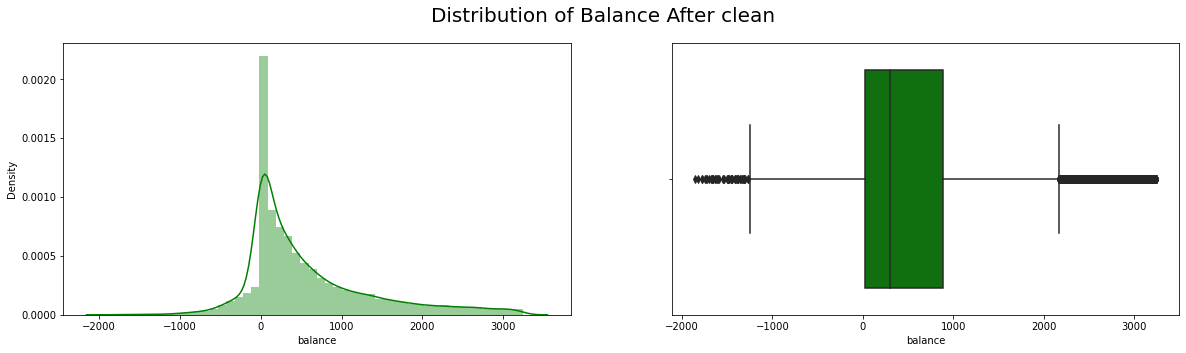

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.suptitle('Distribution of Balance After clean', size=20)
sns.distplot(new_df['balance'],color='g')
plt.subplot(1,2,2)
sns.boxplot(new_df['balance'],color='g')
plt.show()

#### B) Duration

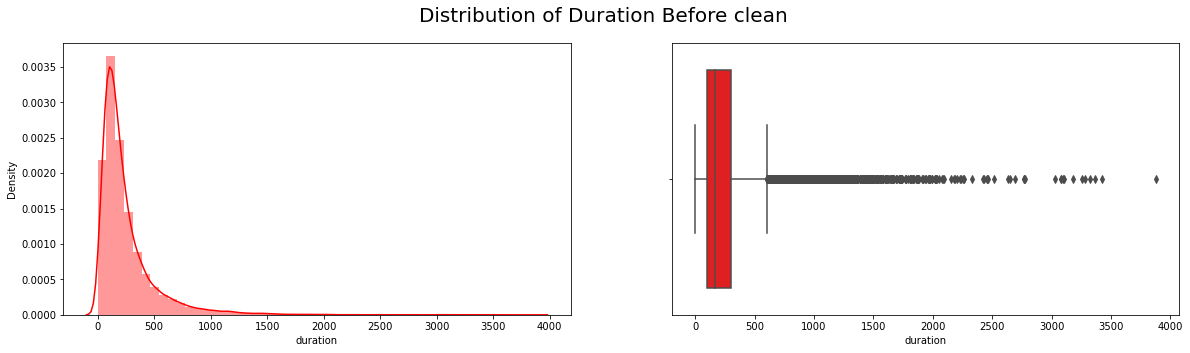

In [14]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20,5))
plt.suptitle('Distribution of Duration Before clean', size=20)
plt.subplot(1,2,1)
sns.distplot(new_df['duration'],color='r')
plt.subplot(1,2,2)
sns.boxplot(new_df['duration'],color='r')
plt.show()

In [15]:
percentile25_d = df['duration'].quantile(0.25)
percentile75_d = df['duration'].quantile(0.75)
iqr_d = percentile75_d - percentile25_d

In [16]:
upper_limit_d = percentile75_d + 1.5 * iqr_d
lower_limit_d = percentile25_d - 1.5 * iqr_d
print('Upper Limit outliers: ',df[df['duration'] > upper_limit_d].shape[0])
print('Lower Limit outliers: ',df[df['duration'] < lower_limit_d].shape[0])

Upper Limit outliers:  2453
Lower Limit outliers:  0


In [17]:
new_df_d = new_df.loc[(new_df['duration'] < upper_limit_d) & (new_df['duration'] > lower_limit_d)]

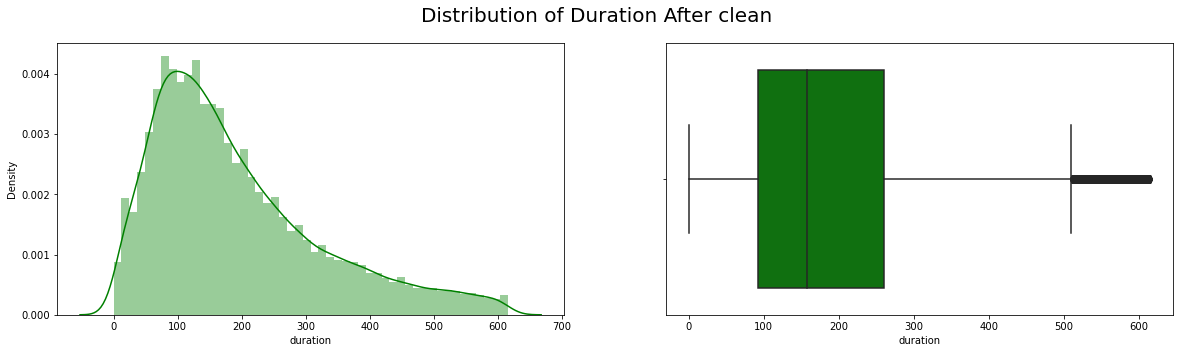

In [18]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(20,5))
plt.suptitle('Distribution of Duration After clean', size=20)
plt.subplot(1,2,1)
sns.distplot(new_df_d['duration'],color='g')
plt.subplot(1,2,2)
sns.boxplot(new_df_d['duration'],color='g')
plt.show()

#### C) Previous Contact

Showing some statistics about "previous contact" feature

In [19]:
new_df_d[['previous']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
previous,25885.0,0.207688,2.088961,0.0,0.0,0.0,0.0,275.0


As we can se in the table, having a mean of 0.2 previous contacts, our max value is 275. That´s only can be explained by outlier observations

In [20]:
limit = new_df_d.previous.mean() + 3*new_df_d.previous.std()

In [21]:
print(f"Percentaje of observations above the limit: {(((new_df_d['previous']>limit).sum() )/ new_df_d.shape[0] * 100).round(2)} %")

Percentaje of observations above the limit: 0.6 %


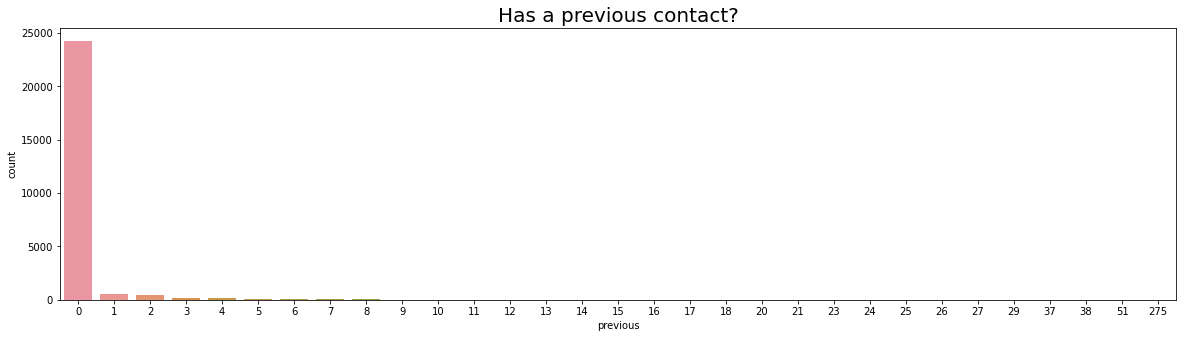

In [22]:
plt.figure(figsize=(20,5));
sns.countplot(new_df_d.previous);
plt.title('Has a previous contact?', size=20);

In [23]:
new_df_p = new_df_d.loc[new_df_d['previous']<limit]

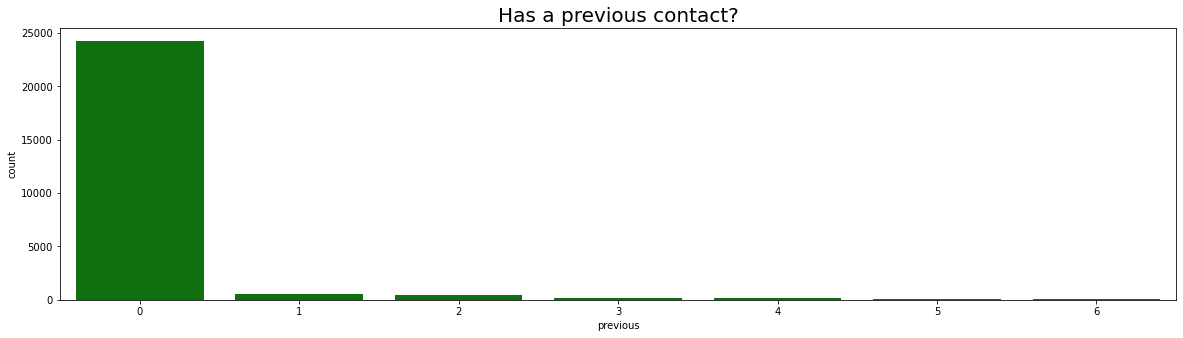

In [24]:
plt.figure(figsize=(20,5));
sns.countplot(new_df_p.previous, color='g');
plt.title('Has a previous contact?', size=20);

### 💡*A brief approach to Data Distribution*

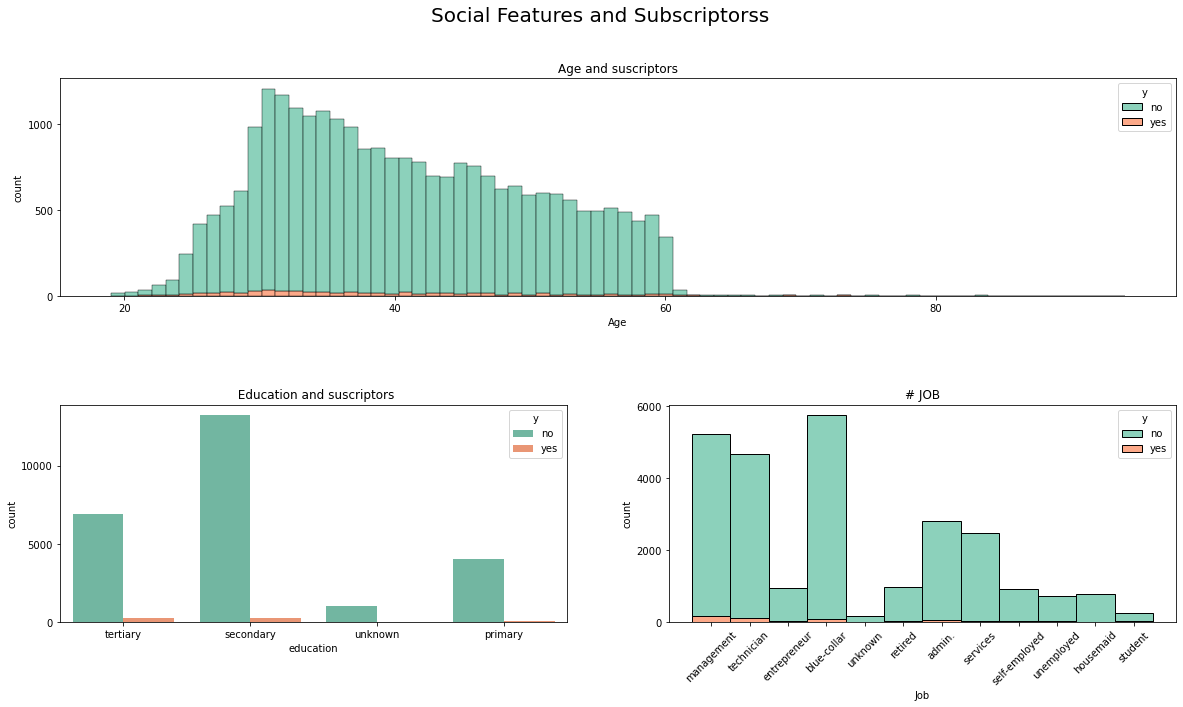

In [25]:
fig = plt.figure(1)
plt.suptitle('Social Features and Subscriptorss',fontsize=20)
# set up subplot grid
gridspec.GridSpec(2,2)

# Small subplot
plt.subplot2grid((2,2), (0,0), colspan=2, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Age and suscriptors')
plt.xlabel('Age')
plt.ylabel('count')
sns.histplot(x='age',hue='y',data=new_df_p,palette='Set2', multiple='stack')


#Large Plot
plt.subplot2grid((2,2), (1,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title(' Education and suscriptors')
plt.xlabel('Education')
plt.ylabel('count')
sns.countplot(x=new_df_p.education,hue=new_df_p.y,palette='Set2')

plt.subplot2grid((2,2), (1,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('# JOB')
plt.xlabel('Job')
plt.ylabel('count')
sns.histplot(x=new_df_p.job,hue=new_df_p.y,palette='Set2', multiple="stack",binwidth=0.1)
plt.xticks(rotation=45)

#Ajusting plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()

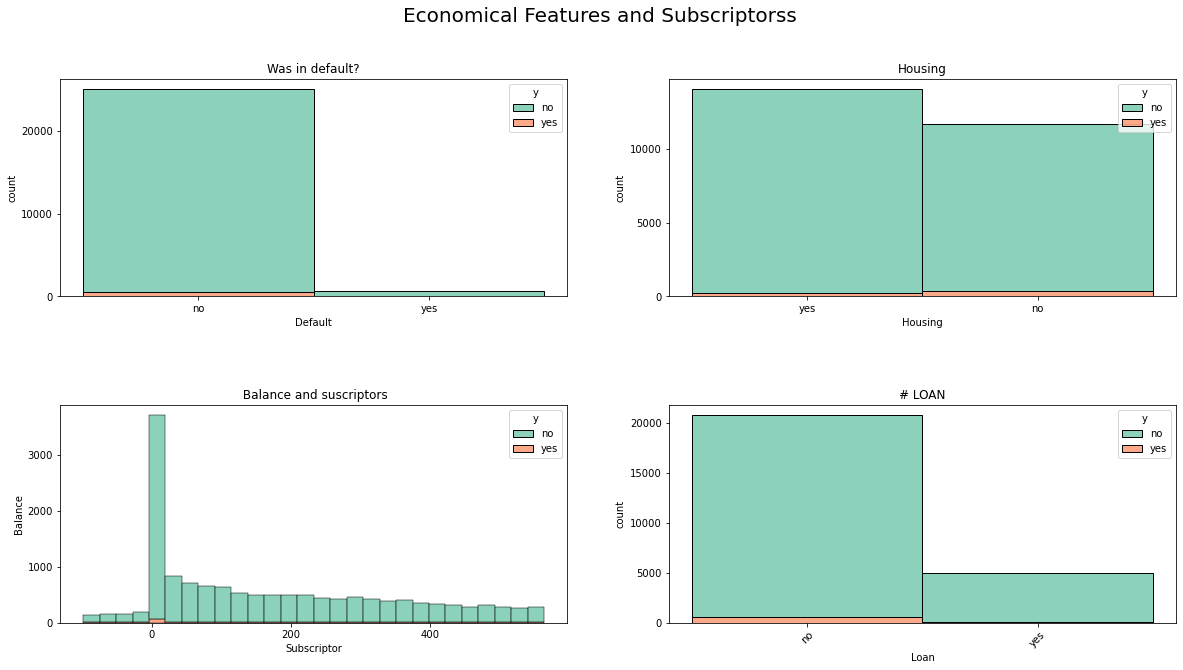

In [26]:
fig = plt.figure(1)
plt.suptitle('Economical Features and Subscriptorss',fontsize=20)
# set up subplot grid


gridspec.GridSpec(2,2)

# Small subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Was in default?')
plt.xlabel('Default')
plt.ylabel('count')
sns.histplot(x='default',hue='y',data=new_df_p,palette='Set2', multiple='stack')


# Small subplot
plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Housing')
plt.xlabel('Housing')
plt.ylabel('count')
sns.histplot(x='housing',hue='y',data=new_df_p,palette='Set2', multiple='stack')

#Large Plot
plt.subplot2grid((2,2), (1,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title(' Balance and suscriptors')
plt.xlabel('Subscriptor')
plt.ylabel('Balance')
sns.histplot(x=new_df_p.balance,hue='y',data = new_df_p.loc[(new_df_p['balance']<(new_df_p.balance.mean())) & (new_df_p['balance']>-100)],palette='Set2', multiple='stack')

plt.subplot2grid((2,2), (1,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('# LOAN')
plt.xlabel('Loan')
plt.ylabel('count')
sns.histplot(x=new_df_p.loan,hue=new_df_p.y,palette='Set2', multiple="stack",binwidth=0.1)
plt.xticks(rotation=45)

#Ajusting plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()

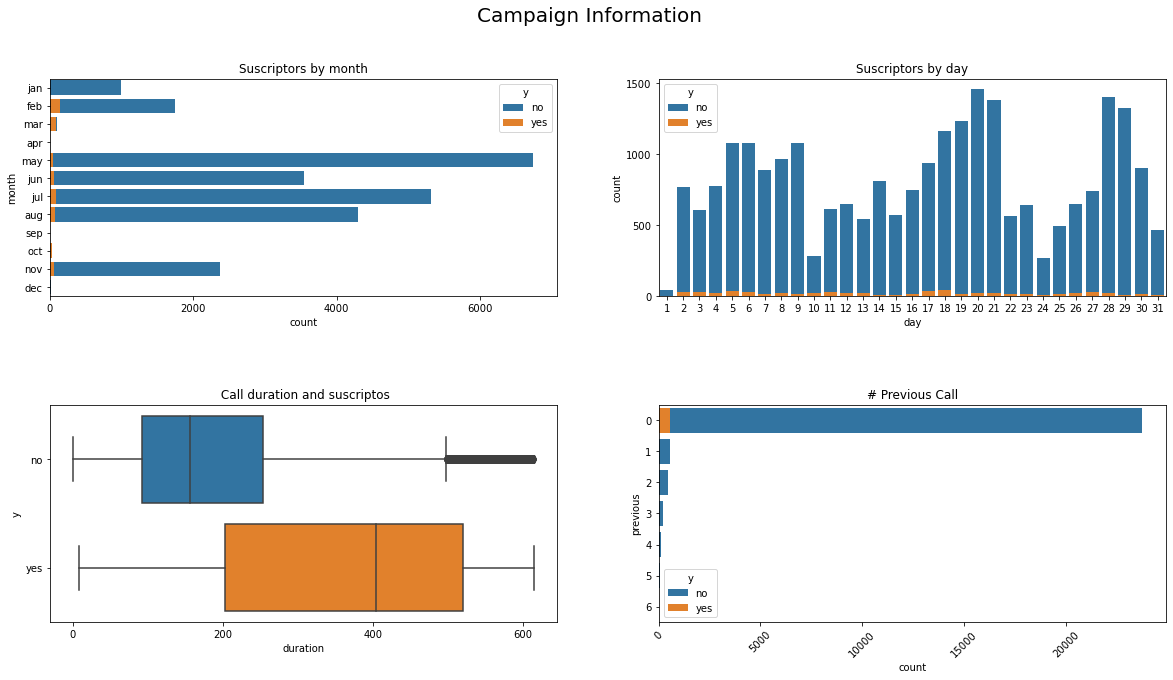

In [27]:
fig = plt.figure(1)
plt.suptitle('Campaign Information',fontsize=20)
# set up subplot grid


gridspec.GridSpec(2,2)

# Small subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Suscriptors by month')
plt.xlabel('Month')
plt.ylabel('count')
sns.countplot(y=new_df_p.month, hue=new_df_p.y, dodge=False, order=['jan', 'feb', 'mar','apr','may','jun','jul','aug','sep', 'oct', 'nov', 'dec'])


# Small subplot
plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('Suscriptors by day')
plt.xlabel('# of day')
plt.ylabel('count')
sns.countplot(new_df_p.day, hue=new_df_p.y, dodge=False)

#Large Plot
plt.subplot2grid((2,2), (1,0), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title(' Call duration and suscriptos')
plt.xlabel('Duration')
plt.ylabel('Suscript')
sns.boxplot(x='duration', data=new_df_p, y='y')

plt.subplot2grid((2,2), (1,1), colspan=1, rowspan=1)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.title('# Previous Call')
plt.xlabel('Count')
plt.ylabel('# of previous calls')
sns.countplot(y='previous', hue='y', data=new_df_p, dodge=False);
plt.xticks(rotation=45)

#Ajusting plot
fig.set_size_inches(w=20,h=10)
plt.subplots_adjust(hspace=.5)
plt.show()

---------------------

## 📌Model Development

#### 💡Droping Correlated features

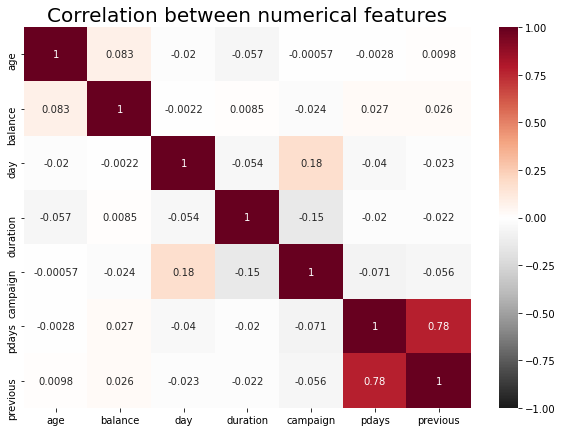

In [28]:
plt.figure(figsize=(10,7))
sns.heatmap(new_df_p.corr(), annot=True, cmap='RdGy_r', vmin=-1, vmax=1);
plt.title('Correlation between numerical features', size=20);

Due we have high correlation between **pDays** and **Previous** features, we will only left one.
As we could see in the previous graph, it's notoriuos how many suscriptors were gotten in the first contact, so it could be intersting use that feature in our model, instead of Pdays.

In [29]:
final_df = new_df_p.drop(columns=['pdays'])

In [30]:
final_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'y'],
      dtype='object')

#### 💡Transforming the target into numerical (binary)

In [31]:
final_df['y'] = final_df.y.apply(lambda x: 1 if x=='yes' else 0)

In [32]:
final_df.y.value_counts()

0    25135
1      595
Name: y, dtype: int64

#### 💡Transforming Month name into numerical

In [33]:
def monthToNum(shortMonth):
    return {
            'jan': 1,
            'feb': 2,
            'mar': 3,
            'apr': 4,
            'may': 5,
            'jun': 6,
            'jul': 7,
            'aug': 8,
            'sep': 9, 
            'oct': 10,
            'nov': 11,
            'dec': 12
    }[shortMonth]

In [34]:
final_df['month']=final_df.month.map(lambda x: monthToNum(x))

#### 💡Getting dummies for our categorical features

In [35]:
df_dummies = pd.get_dummies(final_df, drop_first=True)

In [36]:
display('Shape of our Dataset: ','Rows - Columns',df_dummies.shape);

'Shape of our Dataset: '

'Rows - Columns'

(25730, 32)

In [37]:
df_dummies.columns

Index(['age', 'balance', 'day', 'month', 'duration', 'campaign', 'previous',
       'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

#### 💡Train - Validation Split

<img src='https://www.machinecurve.com/wp-content/uploads/2020/11/feed-2.jpg'>

In machine learning, it is logical that several hours or days are spent trying to optimize our algorithm: select features, transform variables, optimize hyperparameters.
At some point, we will arrive at our final model, which estimates the goal as best as possible. But what if our algorithm learned so well about provided data that it cannot generalize to new data?

**This could be a sign of overfitting.**

Trying to figure that out, we will divide our known data into two different sets: training and test *(in this particular case, we will call it "validation set", because we already have the test data set in another document)*
With the training set up, we will try to run our model to get the best score. Then we will take the X characteristics in the test set, just to predict and then compare with the actual target.

In [38]:
X_train, X_val, y_train, y_val\
                            = train_test_split(df_dummies.drop(['y'], axis=1),\
                                    df_dummies['y'],\
                                    stratify = df_dummies['y'],\
                                    random_state=0)

In [39]:
display('X train', X_train.shape,'X Val', X_val.shape,'Y train', y_train.shape,'Y Val', y_val.shape)

'X train'

(19297, 31)

'X Val'

(6433, 31)

'Y train'

(19297,)

'Y Val'

(6433,)

#### 💡Dealing with unbalanced classes

In [40]:
print('training set:')
print(y_train.value_counts())

print('\nvalidation set:')
print(y_val.value_counts())

training set:
0    18851
1      446
Name: y, dtype: int64

validation set:
0    6284
1     149
Name: y, dtype: int64


In [41]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('training set:')
print(y_train_os.value_counts())

print('\nval set:')
print(y_val.value_counts())

training set:
1    18851
0    18851
Name: y, dtype: int64

val set:
0    6284
1     149
Name: y, dtype: int64


#### 💡Logistic Regression

We will use a logistic regression model, optimizing the hyperparam by cross validation

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6284
           1       0.20      0.01      0.01       149

    accuracy                           0.98      6433
   macro avg       0.59      0.50      0.50      6433
weighted avg       0.96      0.98      0.97      6433

Area under ROC curve: 0.8787
Area under Precision-Recall curve: 0.1527


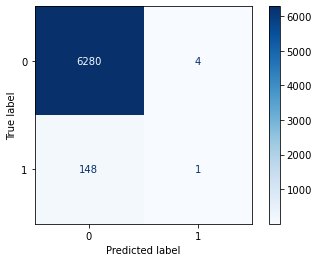

In [42]:
scaler=StandardScaler()  
    
X_train_sc=scaler.fit_transform(X_train) # standarizing data    
X_val_sc=scaler.transform(X_val)
        
model=LogisticRegressionCV(scoring='f1')
    
model.fit(X_train_sc,y_train)
y_pred=model.predict(X_val_sc)
y_proba=model.predict_proba(X_val_sc)
    
print(classification_report(y_val,y_pred))
    
print('Area under ROC curve:',np.round(roc_auc_score(y_val,y_proba[:,1]),4))
    
precision, recall,threshold=precision_recall_curve(y_val,y_proba[:,1]);

print('Area under Precision-Recall curve:',np.round(auc(recall,precision),4))

plot_confusion_matrix(model,X_val_sc,y_val,cmap='Blues');



#### 💡Boosting Classifiers

We will continue working with our copy of features before the standarization, and after the oversampling technique

In [43]:
print('training set:')
print(y_train_os.value_counts())

print('\nval set:')
print(y_val.value_counts())

training set:
1    18851
0    18851
Name: y, dtype: int64

val set:
0    6284
1     149
Name: y, dtype: int64


In [44]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

In [45]:
## We create a function to compare models performance
def evaluate_model(model, name, X, y, cv):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print("Performance of {}:\t{:0.3} ± {:0.3}".format( \
        name, s.mean().round(3), s.std().round(3)))

In [46]:
## Base Model

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=1)

evaluate_model(dt,"Árbol de decisión", X_train_os, y_train_os, cv)

Performance of Árbol de decisión:	0.99 ± 0.0


In [47]:
#Testing AdaBoost and Gradient Boost

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

ab = AdaBoostClassifier(base_estimator=dt, n_estimators=500,random_state=1)
evaluate_model(ab, "AdaBoostClassifier",  X_train_os, y_train_os, cv)

Performance of AdaBoostClassifier:	0.991 ± 0.001


In [48]:
gb = GradientBoostingClassifier()
evaluate_model(gb, "GradientBoostingClassifier", X_train_os, y_train_os, cv)

Performance of GradientBoostingClassifier:	0.917 ± 0.004


In [49]:
# Optimizing hyperparams with gridsearchCv

from sklearn.model_selection import GridSearchCV

params_ab = {"n_estimators": [500,1000],
          "learning_rate":[0.01, 0.1],
        "base_estimator__max_depth": [1, 2, 3]}

grid_ab = GridSearchCV(AdaBoostClassifier(base_estimator=dt,random_state=1), 
                       param_grid=params_ab, cv=cv, verbose=1, n_jobs=3)

In [50]:
grid_ab.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed: 16.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                                          random_state=1),
             n_jobs=3,
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [51]:
grid_ab.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=1000, random_state=1)

In [52]:
evaluate_model(grid_ab.best_estimator_,  "AdaBoostClassifier + GS", X_train_os, y_train_os, cv)

Performance of AdaBoostClassifier + GS:	0.988 ± 0.001


In [53]:
## Optimizing Gradient Boost with CS

params_gb = {'n_estimators':[500, 1000] , 
             'learning_rate':[0.001, 0.001, 0.1],
            'max_depth' : [1, 2, 3, 4]}

grid_gb = GridSearchCV(gb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=3)

In [54]:
grid_gb.fit(X_train_os, y_train_os)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  9.3min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed: 26.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.001, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [55]:
grid_gb.best_estimator_

GradientBoostingClassifier(max_depth=4, n_estimators=1000)

In [57]:
evaluate_model(grid_gb.best_estimator_, "GradientBoostingClassifier + GS", X_train_os, y_train_os, cv)

Performance of GradientBoostingClassifier + GS:	0.987 ± 0.001


### 📌Comparing models and final decision
-----------------------------------------------

#### 💡Performance of AdaBoost Clasifier with Grid Search

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6284
           1       0.28      0.36      0.31       149

    accuracy                           0.96      6433
   macro avg       0.63      0.67      0.65      6433
weighted avg       0.97      0.96      0.97      6433

Area under ROC curve: 0.8597
Area under Precision-Recall curve: 0.2616


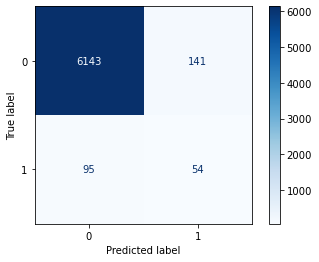

In [58]:
model_ab_cv = grid_ab.best_estimator_

y_pred_ab=model_ab_cv.predict(X_val)
y_proba_ab=model_ab_cv.predict_proba(X_val)
    
print(classification_report(y_val,y_pred_ab))
    
print('Area under ROC curve:',np.round(roc_auc_score(y_val,y_proba_ab[:,1]),4))
    
precision, recall,threshold=precision_recall_curve(y_val,y_proba_ab[:,1]);

print('Area under Precision-Recall curve:',np.round(auc(recall,precision),4))

plot_confusion_matrix(model_ab_cv,X_val,y_val,cmap='Blues');


#### 💡Performance of AdaBoost Clasifier without Grid Search

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6284
           1       0.29      0.30      0.29       149

    accuracy                           0.97      6433
   macro avg       0.64      0.64      0.64      6433
weighted avg       0.97      0.97      0.97      6433

Area under ROC curve: 0.6421
Area under Precision-Recall curve: 0.3024


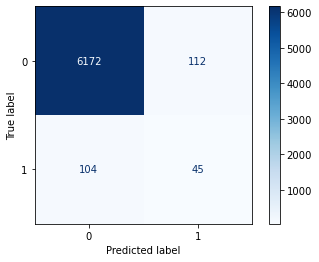

In [63]:
model_ab_2 = ab.fit(X_train_os, y_train_os)

y_pred_ab_2=model_ab_2.predict(X_val)
y_proba_ab_2=model_ab_2.predict_proba(X_val)
    
print(classification_report(y_val,y_pred_ab_2))
    
print('Area under ROC curve:',np.round(roc_auc_score(y_val,y_proba_ab_2[:,1]),4))
    
precision, recall,threshold=precision_recall_curve(y_val,y_proba_ab_2[:,1]);

print('Area under Precision-Recall curve:',np.round(auc(recall,precision),4))

plot_confusion_matrix(model_ab_2,X_val,y_val,cmap='Blues');

#### 💡Performance of AdaBoost Clasifier with Grid Search

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6284
           1       0.35      0.47      0.40       149

    accuracy                           0.97      6433
   macro avg       0.67      0.72      0.69      6433
weighted avg       0.97      0.97      0.97      6433

Area under ROC curve: 0.9394
Area under Precision-Recall curve: 0.4113


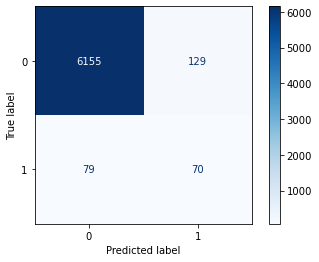

In [64]:
model_gb_gs= grid_gb.best_estimator_

y_pred_gb_gs=model_gb_gs.predict(X_val)
y_proba_gb_gs=model_gb_gs.predict_proba(X_val)
    
print(classification_report(y_val,y_pred_gb_gs))
    
print('Area under ROC curve:',np.round(roc_auc_score(y_val,y_proba_gb_gs[:,1]),4))
    
precision, recall,threshold=precision_recall_curve(y_val,y_proba_gb_gs[:,1]);

print('Area under Precision-Recall curve:',np.round(auc(recall,precision),4))

plot_confusion_matrix(model_gb_gs,X_val,y_val,cmap='Blues');

#### 💡Performance of Gradient Boost Clasifier without Grid Search

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      6284
           1       0.15      0.90      0.26       149

    accuracy                           0.88      6433
   macro avg       0.57      0.89      0.60      6433
weighted avg       0.98      0.88      0.92      6433

Area under ROC curve: 0.9486
Area under Precision-Recall curve: 0.334


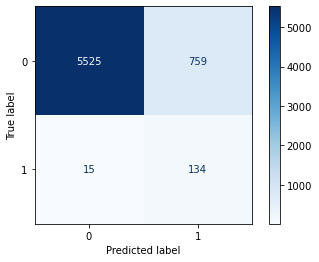

In [65]:
model_gb= gb.fit(X_train_os, y_train_os)

y_pred_gb=model_gb.predict(X_val)
y_proba_gb=model_gb.predict_proba(X_val)
    
print(classification_report(y_val,y_pred_gb))
    
print('Area under ROC curve:',np.round(roc_auc_score(y_val,y_proba_gb[:,1]),4))
    
precision, recall,threshold=precision_recall_curve(y_val,y_proba_gb[:,1]);

print('Area under Precision-Recall curve:',np.round(auc(recall,precision),4))

plot_confusion_matrix(model_gb,X_val,y_val,cmap='Blues');

In [66]:
importances = model_gb.feature_importances_
importances

array([1.38827469e-02, 1.25919330e-02, 6.95998385e-02, 4.20994468e-01,
       3.94564096e-01, 5.03197207e-03, 1.80528149e-03, 1.67440914e-04,
       7.64963863e-04, 0.00000000e+00, 0.00000000e+00, 6.93475571e-04,
       1.45598523e-03, 3.44798029e-04, 0.00000000e+00, 0.00000000e+00,
       1.64405332e-04, 0.00000000e+00, 2.24145455e-03, 1.06612851e-04,
       0.00000000e+00, 3.33561736e-03, 6.99861237e-04, 1.37330373e-04,
       5.55004644e-03, 7.76846234e-03, 3.07954623e-02, 2.44207741e-02,
       1.68485133e-03, 1.32635741e-04, 1.06548663e-03])

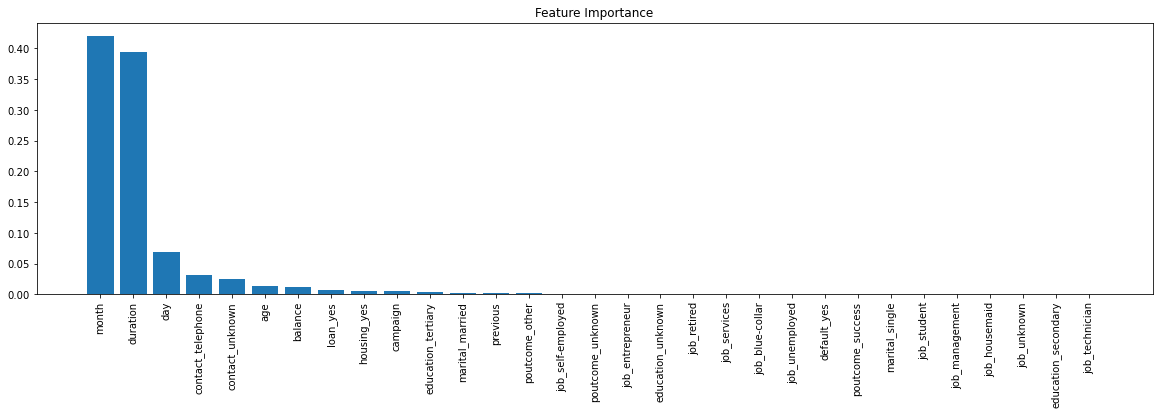

In [67]:

index = np.argsort(importances)[::-1]
names = X_train_os.columns[index]

# Creamos el plot
plt.figure(figsize=(20,5))

# Creamos plot title
plt.title("Feature Importance")

# Agregamos las barras
plt.bar(range(X_train_os.shape[1]), importances[index])

# Agregamos los feature names 
plt.xticks(range(X_train_os.shape[1]), names, rotation=90)

# Show plot
plt.show()

As we could see, with our lastest model we obtained a worse F1 and Precision Score, but we really improved the Recall Score, which represents the percentaje of interested users that our model was able to correctly identify.

So, I decided to choose Gradient Boost Classifier without Grid Search, because I am willing to accept a larger error in the prediction of class 0, if I can find more accuracy in the prediction of enrolled users.

## 📌Predicting new values

In [ ]:
X_test.head(2)

In [ ]:
X_test_final = X_test.drop(columns='pdays')
X_test_final['month']=X_test_final.month.map(lambda x: monthToNum(x))

In [ ]:
X_test_dummies = pd.get_dummies(X_test_final, drop_first=True)
X_test_dummies.columns

In [ ]:
X_train.columns

In [ ]:
y_test_pred=model_gb.predict(X_test_dummies)

In [ ]:
predictions = pd.DataFrame(y_test_pred)
predictions.columns = ['Y_Pred']
predictions.to_csv('predictions_delivery.csv', index=False)

<img src='https://www.observatoriorh.com/wp-content/uploads/2017/05/Thank-you-ok.jpg'>